In [3]:
seed = 0

In [4]:
from utilities.load_data import load_fullECAI
from utilities.evaluation import *
from utilities.evaluation import _my_scorer

In [5]:
import os
import joblib
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer

import shap

C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [7]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic/models/RandomForestClassifier.pkl', 
                './results/Basic/models/LogisticRegression.pkl',
                './results/Basic/models/LinearDiscriminantAnalysis.pkl',
                './results/Basic/models/XGBClassifier.pkl']

model_results = joblib.load(models_paths[0])
shap_df = model_results['shap']

## Graph representation

In [9]:
from igraph import Graph
import igraph as ig
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns

CPU times: total: 906 ms
Wall time: 158 ms


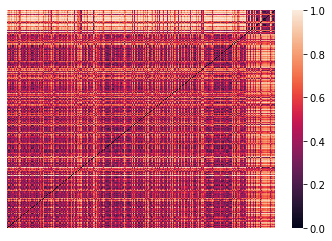

In [39]:
%%time
shap_dist = euclidean_distances(shap_df)

### Sample for testing purposes
shap_df1, _, y_test1, _= train_test_split(shap_df, y_test, train_size=300)
shap_dist = euclidean_distances(shap_df1)
### Sample for testing purposes

normalized_dist = MinMaxScaler().fit_transform(shap_dist)
ax = sns.heatmap(normalized_dist[np.argsort(y_test1).values][:,np.argsort(y_test1).values], xticklabels=False, yticklabels=False)
ax.invert_yaxis()

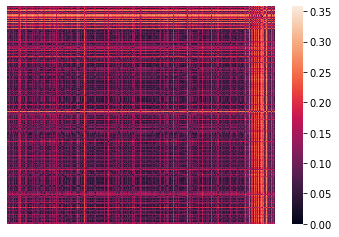

In [33]:
ax = sns.heatmap(shap_dist[np.argsort(y_test).values][:,np.argsort(y_test).values], xticklabels=False, yticklabels=False)
ax.invert_yaxis()
if not os.path.exists('./results/XGBoost/{}/figures/Best'.format(grid_name)):
    os.makedirs('./results/XGBoost/{}/figures/Best'.format(grid_name))
plt.savefig('./results/XGBoost/{}/figures/Best/adjmatrix.png'.format(grid_name), bbox_inches='tight', dpi=300, transparent=True)

# Reduce Dimension

## Criteria: Efficiency

In [44]:
%%time
def nodal_eff(g):
    """
    Finds local nodal efficiency
    
    Source: https://stackoverflow.com/questions/56609704/how-do-i-calculate-the-global-efficiency-of-graph-in-igraph-python
    
    Parameters
    --------
    g : igraph.Graph
        Weighted Graph
    
    Returns
    --------
    ne : float
        Nodal efficiency
    
    Examples
    --------
    # Local efficiency
    >>> eff = nodal_eff(g)
    # Global efficiency
    >>> global_eff = mean(eff)
    """

    
    weights = g.es["weight"][:]
    sp = (1.0 / np.array(g.shortest_paths_dijkstra(weights=weights)))
    np.fill_diagonal(sp,0)
    N=sp.shape[0]
    ne= (1.0/(N-1)) * np.apply_along_axis(sum,0,sp)

    return ne

def mean_eff_from_distances(normalized_dist, cutoff):
    adj_matrix = normalized_dist.copy()
    too_far = adj_matrix > cutoff
    adj_matrix = adj_matrix.astype(object) 
    adj_matrix[too_far] = None # Remove edges between too far vertices
    reduced_G = Graph.Weighted_Adjacency(adj_matrix, mode='undirected', loops=False)
    edges = len(list(reduced_G.es))
    eff = nodal_eff(reduced_G)

    return cutoff, np.mean(eff), edges, reduced_G, adj_matrix

    
def plot_eff_by_cutoff(percent=0.8):
    """
    Plots global (mean) efficienty of network by cutting edges that are too far
    """
    # Estimated time with full graph: 2-3hrs
    cutoffs = np.array(range(1,11))/10
    mean_effs = []
    graphs = []
    
    results = Parallel(n_jobs=-1)(delayed(mean_eff_from_distances)(normalized_dist, co) for co in cutoffs)
    cutoffs, effs, edges, graphs, adj_matrices = list(zip(*results))
    
    optimal_eff = np.max(effs) * percent
    for i, co in enumerate(cutoffs):
        if effs[i] > optimal_eff:
            optimal_cutoff = cutoffs[i]
            optimal_eff = effs[i]
            optimal_adj = adj_matrices[i]
            optimal_G = graphs[i]
            optimal_edges = edges[i]
            break
    
    print('New reduced Graph has {:.2%} edges of the fully connected'.format(optimal_edges/edges[-1]))
    optimals = (optimal_cutoff, optimal_eff, optimal_adj, optimal_G)
    
    plt.plot(cutoffs, effs)
    return effs, edges, optimals, results

## aplicar a la red completa
## Layout circulo

CPU times: total: 0 ns
Wall time: 0 ns


New reduced Graph has 15.59% edges of the fully connected
CPU times: total: 141 ms
Wall time: 1.71 s


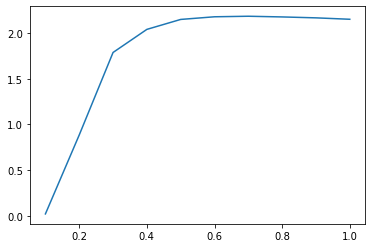

In [45]:
%%time
effs, edges, optimal, results = plot_eff_by_cutoff(percent=0.8)
optimal_cutoff, optimal_eff, optimal_adj, optimal_G = optimal

In [47]:
joblib.dump(results, 'tesssssst.pkl')

['tesssssst.pkl']

In [42]:
colors = np.array(['#808080']*y_test1.shape[0])
colors[y_test1 == 1] = '#FF0000'
optimal_G.vs['color'] = colors.tolist()

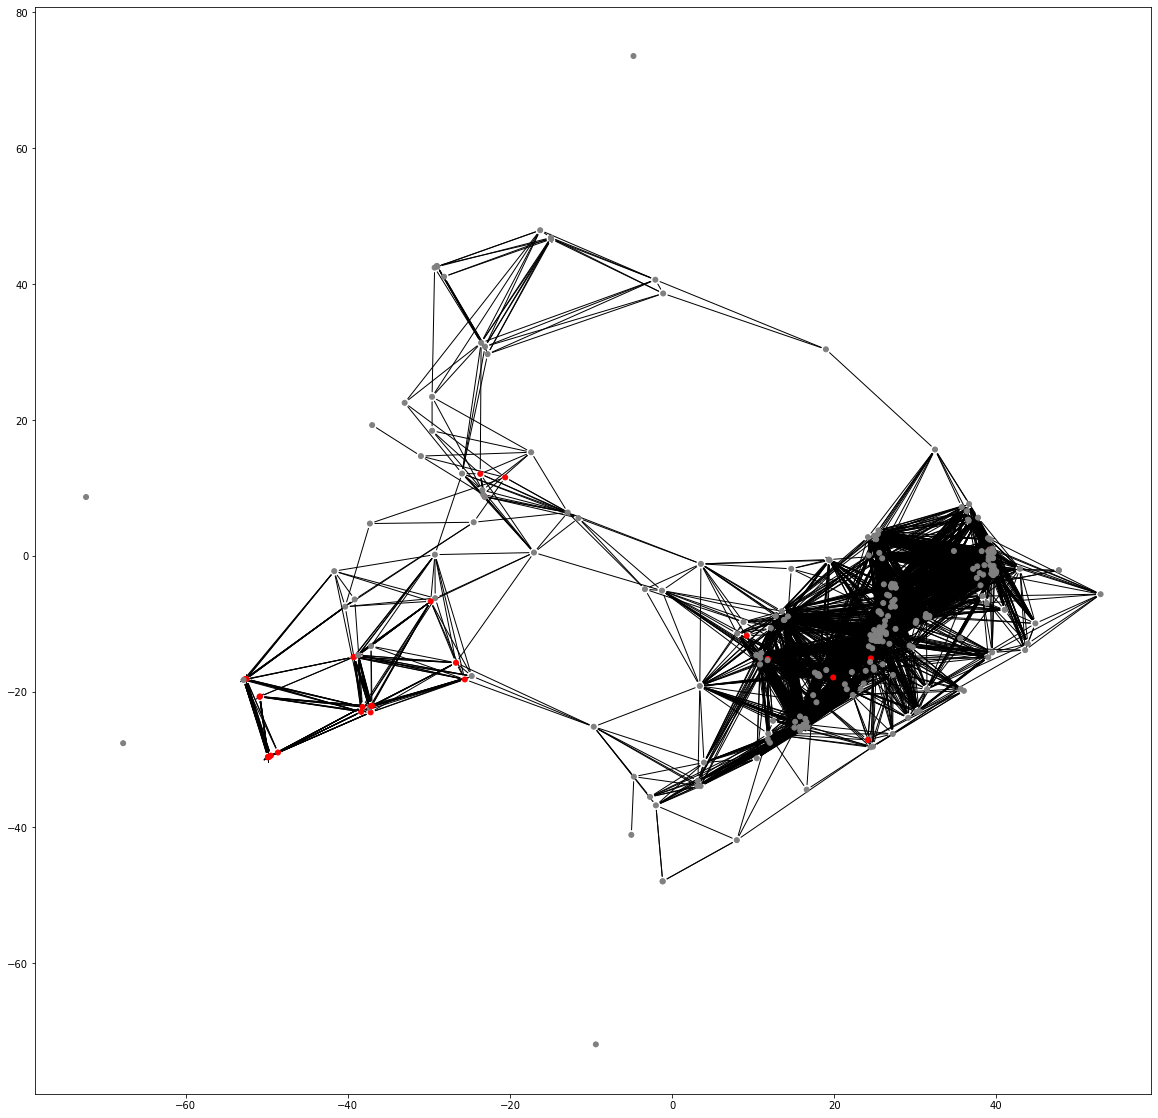

In [43]:
fig, ax = plt.subplots(figsize=(20, 20))
layout = optimal_G.layout_mds()
ig.plot(optimal_G, layout=layout, target=ax, vertex_color=optimal_G.vs['color'])